In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fourier integration evidence calculation


In [30]:
import time, sys, os
import numpy as np
from tqdm.auto import tqdm
import shutil
import warnings
import matplotlib
from matplotlib import pyplot as plt
import bilby
import logging

from funnel.fi_core import get_refernce_lnprior_lnlikelihood, plot_fi_evidence_results, fi_ln_evidence

np.random.seed(42)
warnings.filterwarnings("ignore")

logging.getLogger('bilby').setLevel(logging.CRITICAL)

# re-defining plotting defaults
from matplotlib import rcParams

rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 20})

## Example 1: Linear regression
 We first consider a simple linear regression model with a Gaussian likelihood. We compute the evidence for the model first with nested sampling, and then with the fourier integration method.

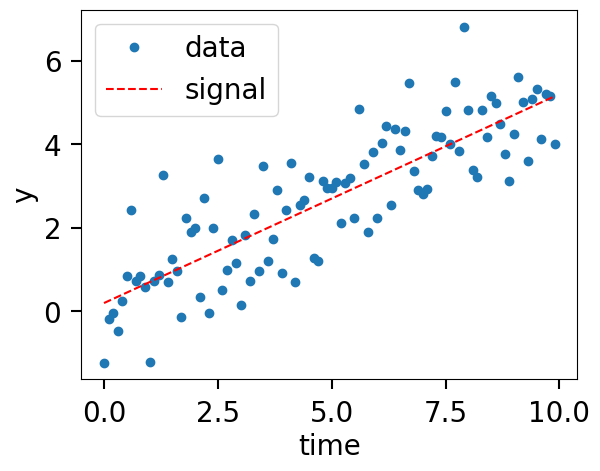

In [31]:
# First, we define our "signal model", in this case a simple linear function
def model(time, m, c):
    return time * m + c


# Now we define the injection parameters which we make simulated data with
injection_parameters = dict(m=0.5, c=0.2)

sampling_frequency = 10
time_duration = 10
time = np.arange(0, time_duration, 1 / sampling_frequency)
N = len(time)
sigma = np.random.normal(1, 0.01, N)
data = model(time, **injection_parameters) + np.random.normal(0, sigma, N)

# We quickly plot the data to check it looks sensible
fig, ax = plt.subplots()
ax.plot(time, data, "o", label="data")
ax.plot(time, model(time, **injection_parameters), "--r", label="signal")
ax.set_xlabel("time")
ax.set_ylabel("y")
ax.legend();


In [32]:

likelihood = bilby.likelihood.GaussianLikelihood(time, data, model, sigma)

priors = bilby.core.prior.PriorDict(dict(
    m=bilby.core.prior.Uniform(0, 5, "m"),
    c=bilby.core.prior.Uniform(-2, 2, "c")
))

outdir, label = 'out', 'line'
if os.path.exists(outdir):
    shutil.rmtree(outdir)
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="dynesty",
    nlive=1500,
    outdir=outdir,
    label=label,
    injection_parameters=injection_parameters,
)

1it [00:00, ?it/s]

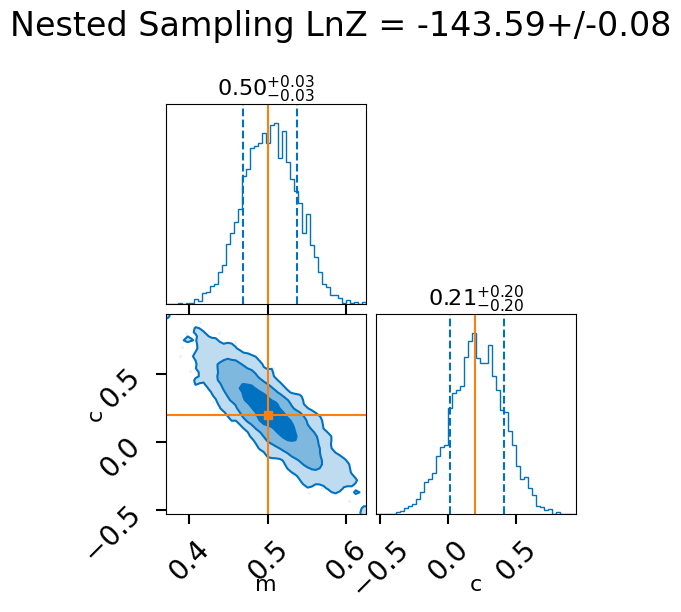

In [33]:
# Finally plot a corner plot: all outputs are stored in outdir
fig = result.plot_corner()
fig.suptitle(f"Nested Sampling LnZ = {result.log_evidence:.2f}+/-{result.log_evidence_err:.2f}", y=1.1);
fig

In [34]:
result.posterior

,m,c,log_likelihood,log_prior
0,0.369660,0.937457,-144.364439,-2.995732
1,0.621746,-0.532072,-143.942106,-2.995732
2,0.571006,0.190029,-143.841540,-2.995732
3,0.552327,-0.378637,-143.753850,-2.995732
4,0.620769,-0.498727,-143.447980,-2.995732
...,...,...,...,...
4113,0.502319,0.207558,-136.801648,-2.995732
4114,0.503415,0.208054,-136.801411,-2.995732
4115,0.502723,0.207181,-136.801178,-2.995732
4116,0.501473,0.213772,-136.801140,-2.995732


0it [00:00, ?it/s]

/home/avaj040/Documents/projects/funnel/src/funnel/fi_core.py:13: RuntimeWarning: invalid value encountered in log
  return np.log(sum_res * const)
/tmp/ipykernel_186423/2960939196.py:2: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


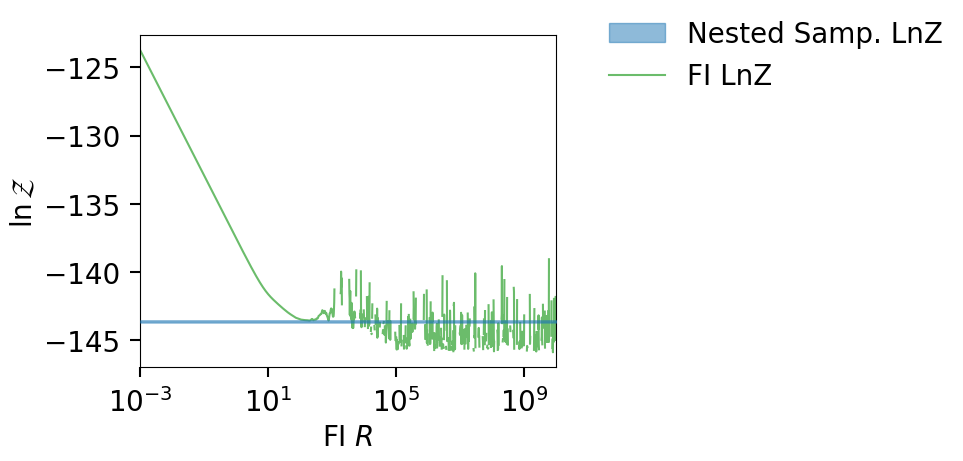

In [15]:
fig = plot_fi_evidence_results(result, priors, likelihood)
fig.tight_layout()


[autoreload of funnel.fi_core failed: Traceback (most recent call last):
  File "/home/avaj040/.cache/pypoetry/virtualenvs/funnel-ZrW66eTN-py3.8/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/avaj040/.cache/pypoetry/virtualenvs/funnel-ZrW66eTN-py3.8/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 844, in exec_module
  File "<frozen importlib._bootstrap_external>", line 981, in get_code
  File "<frozen importlib._bootstrap_external>", line 911, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/avaj040/Documents/projects/funnel/src/funnel/fi_core.py", li

0it [00:00, ?it/s]

/home/avaj040/Documents/projects/funnel/src/funnel/fi_core.py:13: RuntimeWarning: invalid value encountered in log
  return np.log(sum_res * const)
/home/avaj040/Documents/projects/funnel/src/funnel/fi_core.py:13: RuntimeWarning: invalid value encountered in log
  return np.log(sum_res * const)
/home/avaj040/Documents/projects/funnel/src/funnel/fi_core.py:13: RuntimeWarning: invalid value encountered in log
  return np.log(sum_res * const)
/home/avaj040/Documents/projects/funnel/src/funnel/fi_core.py:13: RuntimeWarning: invalid value encountered in log
  return np.log(sum_res * const)
/home/avaj040/Documents/projects/funnel/src/funnel/fi_core.py:13: RuntimeWarning: invalid value encountered in log
  return np.log(sum_res * const)
/home/avaj040/Documents/projects/funnel/src/funnel/fi_core.py:13: RuntimeWarning: invalid value encountered in log
  return np.log(sum_res * const)
/home/avaj040/Documents/projects/funnel/src/funnel/fi_core.py:13: RuntimeWarning: invalid value encountered in l

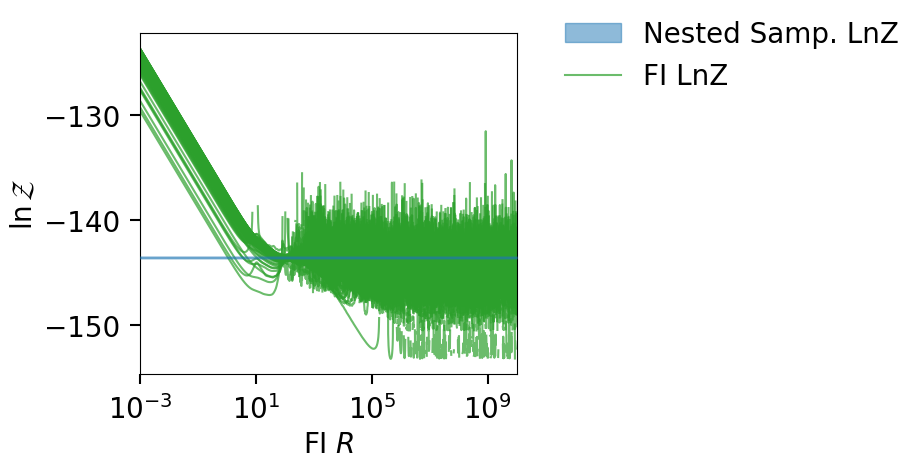

In [28]:
fig = plot_fi_evidence_results(result, priors, likelihood, result.posterior.sample(100).to_dict('records'))

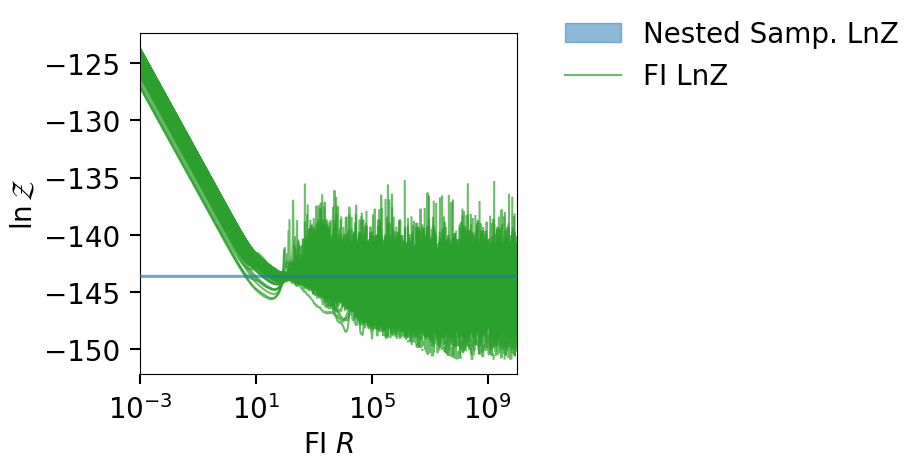

In [24]:
fig

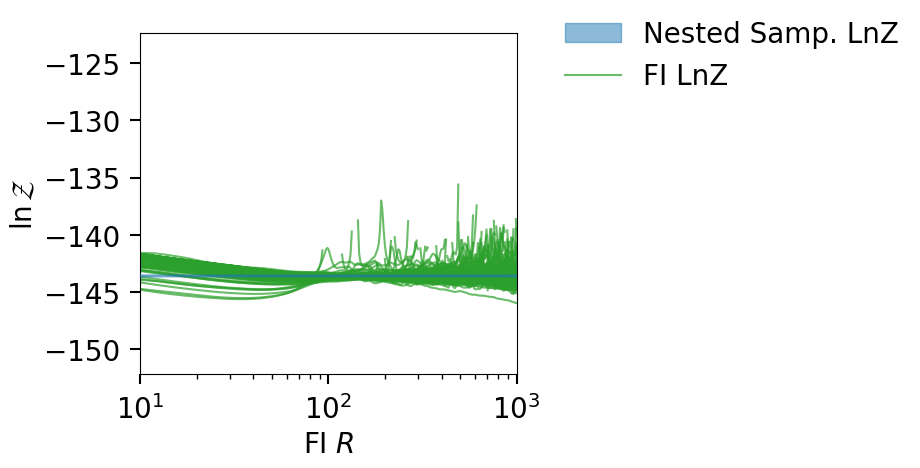

In [27]:
ax = fig.gca()
ax.set_xlim(10,1000)
fig

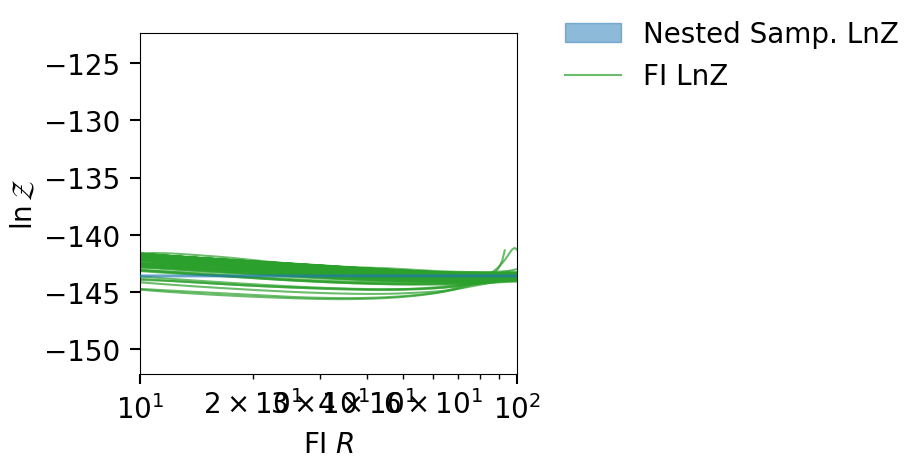

In [26]:
fig